In [3]:
# basics
import numpy as np
import pandas as pd
import datetime
import re
import os,glob

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]

# own data wrappers
from imp import reload
import measureclass as mc; reload(mc);
import coronadataclass as cdc; reload(cdc);
import crossvalidationclass as cvc; reload(cvc);
np.seterr(divide = 'ignore');

In [4]:
crossval = cvc.CrossValidation(verbose = True, SmoothWindowSize = 15, SmoothStdDev = 2)

In [20]:
shiftdaylist = np.arange(11)
alphalist = np.power(10.,np.linspace(-5,-2,num=7))
crossval.StoreResults(reset = True)
crossval.RunCV(shiftdaylist = shiftdaylist, alphalist = alphalist)
crossval.StoreResults('data/results_cw_200423.csv')

  0 0.000010        21:55:06
  0 0.000032        21:58:49
  0 0.000100        22:01:50
  0 0.000316        22:04:06
  0 0.001000        22:05:27
  0 0.003162        22:06:13
  0 0.010000        22:06:49
  1 0.000010        22:10:59
  1 0.000032        22:14:44
  1 0.000100        22:17:45
  1 0.000316        22:19:58
  1 0.001000        22:21:21
  1 0.003162        22:22:10
  1 0.010000        22:22:46
  2 0.000010        22:27:03
  2 0.000032        22:30:52
  2 0.000100        22:34:16
  2 0.000316        22:36:35
  2 0.001000        22:38:01
  2 0.003162        22:38:50
  2 0.010000        22:39:28
  3 0.000010        22:43:37
  3 0.000032        22:47:27
  3 0.000100        22:50:32
  3 0.000316        22:52:42
  3 0.001000        22:54:09
  3 0.003162        22:54:58
  3 0.010000        22:55:38
  4 0.000010        22:59:53
  4 0.000032        23:03:41
  4 0.000100        23:06:42
  4 0.000316        23:08:49
  4 0.001000        23:10:10
  4 0.003162        23:10:59
  4 0.010000  

data/results_cw_200423_detailed.csv


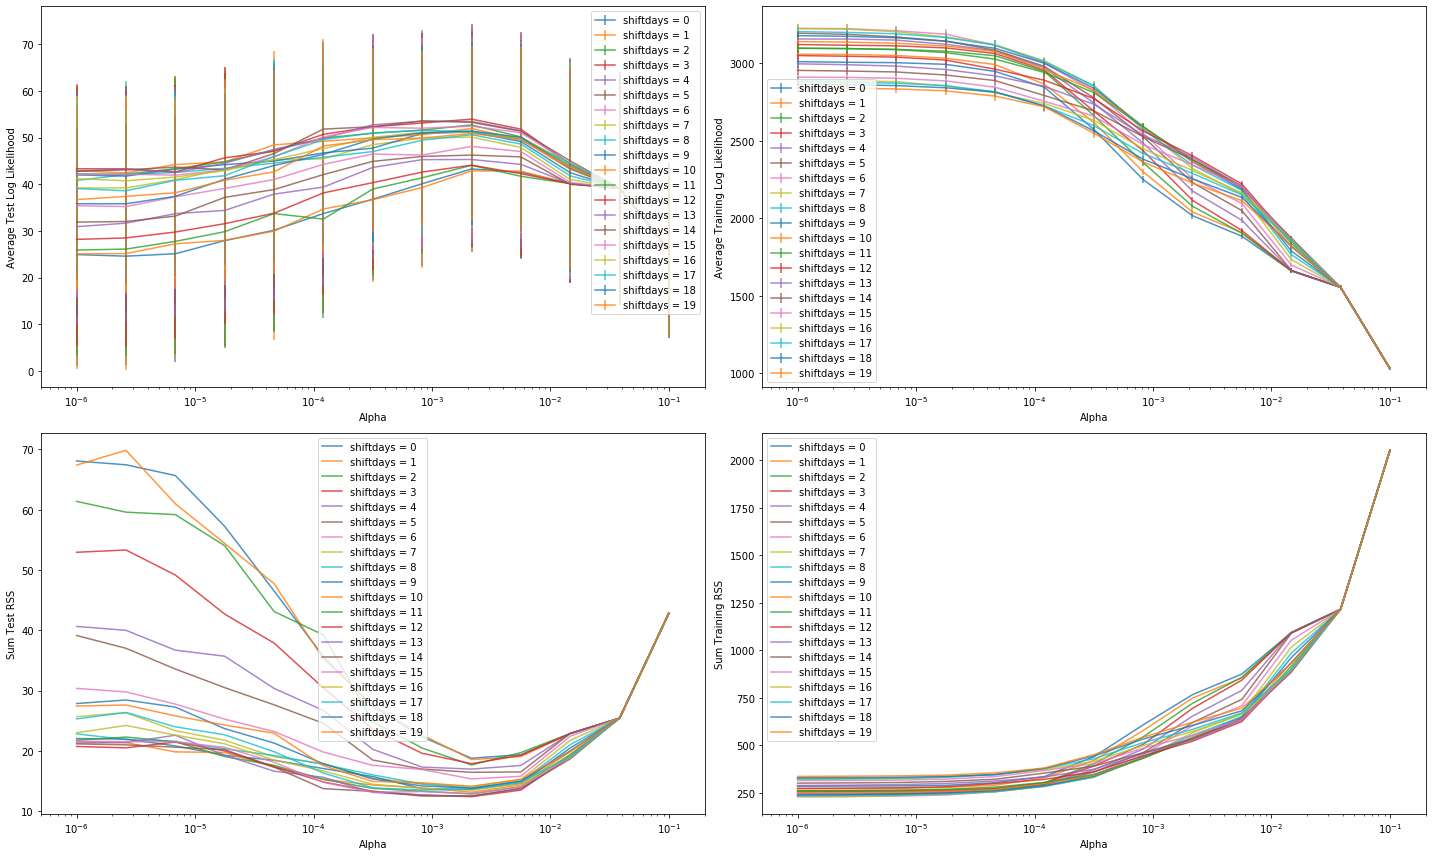

In [2]:
filelist = ['data/results_cw_200423.csv', 'data/results_cw_200423.csv']
filelist2 = ['data/results_cw_200423_detailed.csv']
            
# plot test errors
markerlist = ['o','x','v','^','p','P','h','D','s','X','>','<']
colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]
alldata    = []
resDF      = None

fig,axis   = plt.subplots(2,2,figsize = (20,12))
ax         = axis.flatten()

for i,fn in enumerate(filelist2):
    if os.path.exists(fn):
        print(fn)
        alldata.append(pd.read_csv(fn))

        shiftdaylist = np.array(alldata[i]['shiftdays'].unique(),dtype=np.int)
        alphalist    = alldata[i]['alpha'].unique()
        
        # compute averages and stddev with pandas
        curavg = alldata[i].groupby(['shiftdays','alpha'], as_index = False).agg(
            { 'Loglike Test':['mean','std'],
              'Loglike Training':['mean','std'],
              'R2 Test': ['mean','std'],
              'R2 Training': ['mean','std'],
              'RSS Training' : ['sum'],
              'RSS Test': ['sum']
            })
        #print(curavg)
        # rename columns in new DF
        curavg.columns = ['shiftdays','alpha',
                          'Loglike Test','Loglike Test Std',
                          'Loglike Training','Loglike Training Std',
                          'R2 Test','R2 Test Std',
                          'R2 Training','R2 Training Std',
                          'RSS Training Sum',
                          'RSS Test Sum'
                         ]
        # add more columns to identify results
        curavg['filename']  = fn
        curavg['iteration'] = i

        if resDF is None: resDF = pd.DataFrame(curavg)
        else:             resDF = pd.concat([resDF,curavg])


resDF.sort_values(by = ['shiftdays','alpha'],inplace = True)
alphalist = resDF['alpha'].unique()

for shiftdays in resDF['shiftdays'].unique():
        boolidx = np.array(resDF['shiftdays'] == shiftdays)
        alphalist = resDF[boolidx]['alpha']
        ax[0].errorbar(alphalist, resDF[boolidx]['Loglike Test'],     yerr = resDF[boolidx]['Loglike Test Std'],     c = colornames[int(shiftdays) % len(colornames)], alpha = .8, label= 'shiftdays = {}'.format(shiftdays))
        ax[1].errorbar(alphalist, resDF[boolidx]['Loglike Training'], yerr = resDF[boolidx]['Loglike Training Std'], c = colornames[int(shiftdays) % len(colornames)], alpha = .8, label= 'shiftdays = {}'.format(shiftdays))
        ax[2].errorbar(alphalist, resDF[boolidx]['RSS Test Sum'],        c = colornames[int(shiftdays) % len(colornames)], alpha = .8, label= 'shiftdays = {}'.format(shiftdays))
        ax[3].errorbar(alphalist, resDF[boolidx]['RSS Training Sum'],    c = colornames[int(shiftdays) % len(colornames)], alpha = .8, label= 'shiftdays = {}'.format(shiftdays))


# compute average and plot it
#alphalist    = resDF['alpha'].unique()
#totalavg     = resDF.groupby(['shiftdays','alpha'], as_index = False).agg(
#                            { 'Loglike Test':['mean','std'],
#                              'Loglike Training':['mean','std'],
#                              'R2 Test': ['mean','std'],
#                              'R2 Training': ['mean','std']
#                            })
        
# rename columns in new DF
#totalavg.columns = ['shiftdays','alpha',
#                    'Loglike Test','Loglike Test Std',
#                    'Loglike Training','Loglike Training Std',
#                    'R2 Test','R2 Test Std',
#                    'R2 Training','R2 Training Std'
#                     ]



#for shiftdays in totalavg['shiftdays'].unique():
#    boolidx = np.array(totalavg['shiftdays'] == shiftdays)
#    ax[0].errorbar(alphalist, totalavg[boolidx]['Loglike Test'],     yerr = totalavg[boolidx]['Loglike Test Std'],     c = colornames[int(shiftdays) % len(colornames)], alpha = .8, lw = 3, label = 'shiftdays = {:.0f}'.format(shiftdays))
#    ax[1].errorbar(alphalist, totalavg[boolidx]['Loglike Training'], yerr = totalavg[boolidx]['Loglike Training Std'], c = colornames[int(shiftdays) % len(colornames)], alpha = .8, lw = 3, label = 'shiftdays = {:.0f}'.format(shiftdays))
#    ax[2].errorbar(alphalist, totalavg[boolidx]['R2 Test'],          yerr = totalavg[boolidx]['R2 Test Std'],          c = colornames[int(shiftdays) % len(colornames)], alpha = .8, lw = 3, label = 'shiftdays = {:.0f}'.format(shiftdays))
#    ax[3].errorbar(alphalist, totalavg[boolidx]['R2 Training'],      yerr = totalavg[boolidx]['R2 Training Std'],      c = colornames[int(shiftdays) % len(colornames)], alpha = .8, lw = 3, label = 'shiftdays = {:.0f}'.format(shiftdays))

for i in range(4):
    ax[i].set_xlim([1e-6/2,2e-1])
    ax[i].set_xscale('log')
    ax[i].set_xlabel(r'Alpha')
    ax[i].legend()
    
ax[0].set_ylabel('Average Test Log Likelihood')
ax[1].set_ylabel('Average Training Log Likelihood')
ax[2].set_ylabel('Sum Test RSS')
ax[3].set_ylabel('Sum Training RSS')

#ax[0].set_ylim([1.12,1.34])
#ax[1].set_ylim([1.12,1.34])
#ax[2].set_ylim([.45,.63])
#ax[3].set_ylim([.45,.63])

fig.tight_layout()
plt.savefig('loglikelihood_country_smooth.pdf')


In [5]:
cvdata = pd.read_csv('data/results_cw_200423_detailed.csv')

In [19]:
cvprocess = crossval.ProcessCVdata(cvdata)
columns = list(cvprocess.columns)
print(columns)
cvprocess.sort_values(by = 'RSS Test Sum',inplace = True)

for index,values in cvprocess.iterrows():
    print(' '.join(['{:8.3f}'.format(values[x]) for x in columns]))


['shiftdays', 'alpha', 'Loglike Test', 'Loglike Test Std', 'Loglike Training', 'Loglike Training Std', 'R2 Test', 'R2 Test Std', 'R2 Training', 'R2 Training Std', 'RSS Training Sum', 'RSS Test Sum']
  12.000    0.002   53.941   20.432 2403.239   21.633   -0.408    3.160    0.514    0.008  520.986   12.417
  13.000    0.002   53.446   20.331 2392.783   22.534   -0.466    3.345    0.509    0.008  526.459   12.484
  14.000    0.001   53.563   18.878 2526.739   23.711   -0.335    1.969    0.570    0.006  460.535   12.519
  14.000    0.002   53.257   19.253 2378.673   20.844   -0.140    1.518    0.502    0.007  533.906   12.547
  12.000    0.001   53.105   19.273 2563.281   24.693   -0.891    4.955    0.586    0.008  444.024   12.670
  13.000    0.001   53.479   19.476 2536.406   23.493   -0.715    4.079    0.574    0.007  456.115   12.703
  11.000    0.002   52.698   18.707 2378.117   21.706   -0.728    4.815    0.502    0.008  534.208   12.875
  15.000    0.002   52.441   19.169 2345.083 